# Final Project (Opal Issan)

In [1]:
import numpy as np
import scipy.linalg as la
from scipy import stats
from scipy.interpolate import interp1d
import scipy
import time
from scipy.sparse import diags
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import copy

In [2]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

# Problem 1


# (b) Implementation of the two-dimensional Heat (or Diffusion) Equation 

In [3]:
# intitialize paramters 
a = 2
alpha = 0.1
dx = 0.0125
dy = 0.0125
omega = 50

Nx = 81 
Ny = 81

x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)

X, Y = np.meshgrid(x, y)


Nt = 1001

t = np.linspace(0, 4, Nt)
dt = t[1]-t[0]
print(dt)

0.004


In [4]:
beta = alpha*dt/(2*(dx**2))
beta

1.2799999999999998

In [5]:
def source(x, y, t):
    # should return a vector since x and y are vectors. 
    function_f = 1 - np.exp(-a*t)*np.sin(omega*t) * np.cos(2*omega*t)
    
    mat = np.zeros((Nx, Ny))
    for ii in range(Nx):
        for jj in range(Ny):
            mat[ii, jj] = 2.5*np.sin(4*np.pi*x[ii])* np.sin(8*np.pi*y[jj]) * function_f
    return mat

In [6]:
# Now, form the differential operator Ax. 
Ax = diags(-2*np.ones(Nx-2), 0).toarray()
Ax += diags(np.ones(Nx - 3), -1).toarray()
Ax += diags(np.ones(Nx - 3), 1).toarray()

Ax = Ax/(dx**2)

6399.999999999999
[[-12800.   6400.      0. ...      0.      0.      0.]
 [  6400. -12800.   6400. ...      0.      0.      0.]
 [     0.   6400. -12800. ...      0.      0.      0.]
 ...
 [     0.      0.      0. ... -12800.   6400.      0.]
 [     0.      0.      0. ...   6400. -12800.   6400.]
 [     0.      0.      0. ...      0.   6400. -12800.]]


In [7]:
# Now, form the differential operator Ay. 
Ay = diags(-2*np.ones(Ny -2), 0).toarray()
Ay += diags(np.ones(Ny - 3), -1).toarray()
Ay += diags(np.ones(Ny - 3), 1).toarray()

Ay = Ay/(dy**2)

In [8]:
## solving a system of equations with tri-diag matrix Ax = d via the Thomas Algorithm 
def thomas_solver(A, d):
    # d is the rhs vector when solving the system Ax = d.
    
    # a, b, c are the diagonal vectors where b is the main diag c is above diag and a is below. 
    a = np.diag(A, -1)
    b = np.diag(A, 0)
    c = np.diag(A, 1)
    
    N = len(d) # dimension of RHS vector. 
    
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays
    
    for kk in range(1, N):
        mc = ac[kk-1]/bc[kk-1]
        bc[kk] = bc[kk] - mc*cc[kk-1] 
        dc[kk] = dc[kk] - mc*dc[kk-1]
        
    xc = np.copy(bc)
    xc[-1] = dc[-1]/bc[-1]

    for jj in range(N-2, -1, -1):
        xc[jj] = (dc[jj]-cc[jj]*xc[jj+1])/bc[jj]

    return xc

In [9]:
res = np.zeros((Nx, Ny, Nt))

# initial condition 
res[:, :, 0] =  0.01*np.outer(np.sin(np.pi*x), np.sin(np.pi*y))


for ii in range(Nt -1):
    # step 1.
    # RHS Matrix 
    RHS = np.zeros((Nx, Ny))
    
    
    for jj in range(1, Nx):
        RHS[jj, 1:-1] = res[jj, 1:-1, ii] + alpha*dt/2 * np.matmul(Ay, res[jj, 1:-1, ii])
    
    # add source
    RHS = RHS + dt/2*source(x, y, t[ii])
        
    # step 1: solve the first linear equation using thomas algorithm. 
    A_MAT_1 = (np.eye(Nx-2) - alpha*dt/2 *Ax)

    LHS_1 = np.zeros((Nx, Ny))
    for jj in range(1, Ny -1):
        LHS_1[1:-1, jj] = thomas_solver(A=A_MAT_1, d=RHS[1:-1, jj])
        
    # boundary conditions
    LHS_1[:, 0] = 0
    LHS_1[:, -1] = 0
    LHS_1[0, :] = 0
    LHS_1[-1, :] = 0
    
    #step 2
    # RHS Matrix 
    RHS = np.zeros((Nx, Ny))
    
    for jj in range(1, Ny -1):
        RHS[1:-1, jj] = LHS_1[1:-1, jj] + alpha*dt/2 * np.matmul(Ax, LHS_1[1:-1, jj])
    
    # add source
    RHS = RHS + dt/2*source(x, y, t[ii + 1])
    
            
    # boundary conditions
    RHS[:, 0] = 0
    RHS[:, -1] = 0
    RHS[0, :] = 0
    RHS[-1, :] = 0
    
    
    # step 2: solve the second linear equation using thomas algorithm. 
    A_MAT_2 = (np.eye(Ny-2) - alpha*dt/2 *Ay)

    for kk in range(1, Nx -1):
        res[kk, 1:-1, ii + 1] = thomas_solver(A=A_MAT_2, d=RHS[kk, 1:-1])

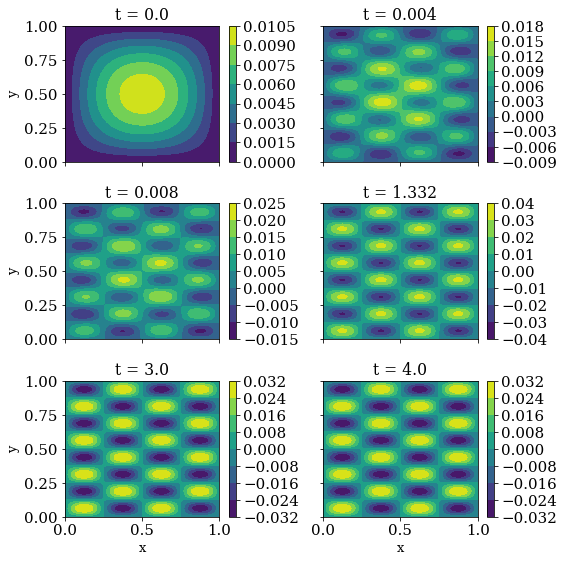

In [10]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, sharey=True, figsize=(8, 8))

N1, N2, N3, N4, N5, N6= 0, 1, 2, Nt//3, 3*Nt//4, Nt-1

pos = ax[0, 0].contourf(X, Y, res[:, :, N1].T)
fig.colorbar(pos, ax=ax[0, 0])
ax[0, 0].set_title("t = " + str(round(t[N1], 2)))
ax[0, 0].set_ylabel("y")

pos = ax[0, 1].contourf(X, Y, res[:, :, N2].T)
fig.colorbar(pos, ax=ax[0, 1])
ax[0, 1].set_title("t = " + str(round(t[N2], 3)))

pos = ax[1, 0].contourf(X, Y, res[:, :, N3].T)
fig.colorbar(pos, ax=ax[1, 0])
ax[1, 0].set_title("t = " + str(round(t[N3], 3)))
ax[1, 0].set_ylabel("y")

pos = ax[1, 1].contourf(X, Y, res[:, :, N4].T)
fig.colorbar(pos, ax=ax[1, 1])
ax[1, 1].set_title("t = " + str(round(t[N4], 3)))

pos = ax[2, 0].contourf(X, Y, res[:, :, N5].T)
fig.colorbar(pos, ax=ax[2, 0])
ax[2, 0].set_title("t = " + str(round(t[N5], 3)))
ax[2, 0].set_xlabel("x")
ax[2, 0].set_ylabel("y")

pos = ax[2, 1].contourf(X, Y, res[:, :, N6].T)
fig.colorbar(pos, ax=ax[2, 1])
ax[2, 1].set_title("t = " + str(round(t[N6], 3)))
ax[2, 1].set_xlabel("x")


plt.tight_layout()

plt.savefig("figs5/contour_plot_temp.png", dpi=600)

In [11]:
x_coord = np.argmin( np.abs(x - 0.55))
y_coord = np.argmin( np.abs(y - 0.45))

print(x_coord)
print(y_coord)

44
36


0.45

# Steady-state solution

In [12]:
steady_state = np.zeros((Nx, Ny))
K = 2.5/((80*alpha)*(np.pi**2))

for ii in range(Nx):
    for jj in range(Ny):
        steady_state[ii, jj] = K*np.sin(4*np.pi*x[ii])*np.sin(8*np.pi*y[jj])

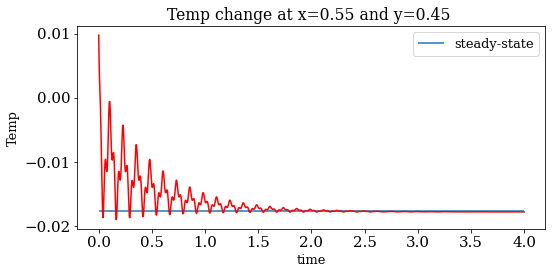

In [13]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t, res[x_coord, y_coord], c="r")
res1 = np.copy(res)
ax.hlines(xmin=0, xmax=4, y=steady_state[x_coord, y_coord], label="steady-state")
ax.set_xlabel("time")
ax.set_ylabel("Temp")
ax.set_title("Temp change at x=0.55 and y=0.45 ")
plt.legend()
plt.tight_layout()
plt.savefig("figs5/temp_change_x_y.png", dpi=500)

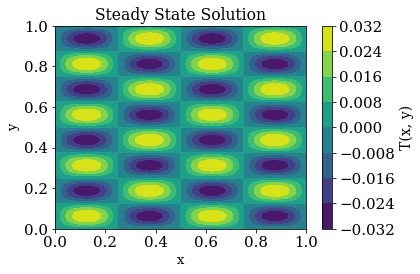

In [14]:
fig, ax = plt.subplots()

pos = ax.contourf(X, Y, steady_state.T)
ax.set_xlabel("x")
ax.set_ylabel("y")
cbar = fig.colorbar(pos, ax=ax)
cbar.ax.set_ylabel('T(x, y)', rotation=90, fontsize=14)

ax.set_title("Steady State Solution")

plt.tight_layout()
plt.savefig("figs5/steady_state.png", dpi=500)

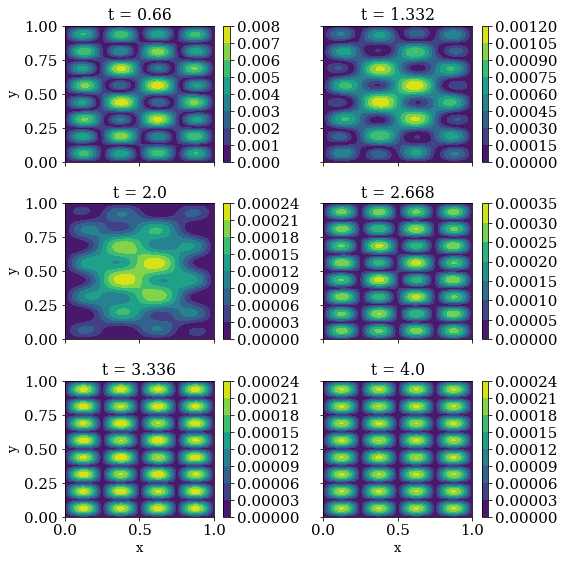

In [15]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, sharey=True, figsize=(8, 8))

N1, N2, N3, N4, N5, N6=  Nt//6, 2*Nt//6, 3*Nt//6, 4*Nt//6, 5*Nt//6, Nt-1

pos = ax[0, 0].contourf(X, Y, np.abs(steady_state - res[:, :, N1]).T)
fig.colorbar(pos, ax=ax[0, 0])
ax[0, 0].set_title("t = " + str(round(t[N1], 2)))
ax[0, 0].set_ylabel("y")

pos = ax[0, 1].contourf(X, Y, np.abs(steady_state - res[:, :, N2]).T)
fig.colorbar(pos, ax=ax[0, 1])
ax[0, 1].set_title("t = " + str(round(t[N2], 3)))

pos = ax[1, 0].contourf(X, Y, np.abs(steady_state - res[:, :, N3]).T)
fig.colorbar(pos, ax=ax[1, 0])
ax[1, 0].set_title("t = " + str(round(t[N3], 3)))
ax[1, 0].set_ylabel("y")

pos = ax[1, 1].contourf(X, Y, np.abs(steady_state - res[:, :, N4]).T)
fig.colorbar(pos, ax=ax[1, 1])
ax[1, 1].set_title("t = " + str(round(t[N4], 3)))

pos = ax[2, 0].contourf(X, Y, np.abs(steady_state - res[:, :, N5]).T)
fig.colorbar(pos, ax=ax[2, 0])
ax[2, 0].set_title("t = " + str(round(t[N5], 3)))
ax[2, 0].set_xlabel("x")
ax[2, 0].set_ylabel("y")

pos = ax[2, 1].contourf(X, Y, np.abs(steady_state - res[:, :, N6]).T)
fig.colorbar(pos, ax=ax[2, 1])
ax[2, 1].set_title("t = " + str(round(t[N6], 3)))
ax[2, 1].set_xlabel("x")


plt.tight_layout()

plt.savefig("figs5/contour_plot_temp_abs_error.png", dpi=600)

# (d)

In [16]:
res = np.zeros((Nx, Ny, Nt))

# initial condition 
# res[:, :, 0] =  0.01*np.outer(np.sin(np.pi*x), np.sin(np.pi*y))


for ii in range(Nt -1):
    # step 1.
    # RHS Matrix 
    RHS = np.zeros((Nx, Ny))
    
    
    for jj in range(1, Nx):
        RHS[jj, 1:-1] = res[jj, 1:-1, ii] + alpha*dt/2 * np.matmul(Ay, res[jj, 1:-1, ii])
    
    # add source
    RHS = RHS + dt/2*source(x, y, t[ii])
        
    # step 1: solve the first linear equation using thomas algorithm. 
    A_MAT_1 = (np.eye(Nx-2) - alpha*dt/2 *Ax)

    LHS_1 = np.zeros((Nx, Ny))
    for jj in range(1, Ny -1):
        LHS_1[1:-1, jj] = thomas_solver(A=A_MAT_1, d=RHS[1:-1, jj])
        
    # boundary conditions
    LHS_1[:, 0] = 0
    LHS_1[:, -1] = 0
    LHS_1[0, :] = 0
    LHS_1[-1, :] = 0
    
    #step 2
    # RHS Matrix 
    RHS = np.zeros((Nx, Ny))
    
    for jj in range(1, Ny -1):
        RHS[1:-1, jj] = LHS_1[1:-1, jj] + alpha*dt/2 * np.matmul(Ax, LHS_1[1:-1, jj])
    
    # add source
    RHS = RHS + dt/2*source(x, y, t[ii + 1])
    
            
    # boundary conditions
    RHS[:, 0] = 0
    RHS[:, -1] = 0
    RHS[0, :] = 0
    RHS[-1, :] = 0
    
    
    # step 2: solve the second linear equation using thomas algorithm. 
    A_MAT_2 = (np.eye(Ny-2) - alpha*dt/2 *Ay)

    for kk in range(1, Nx -1):
        res[kk, 1:-1, ii + 1] = thomas_solver(A=A_MAT_2, d=RHS[kk, 1:-1])

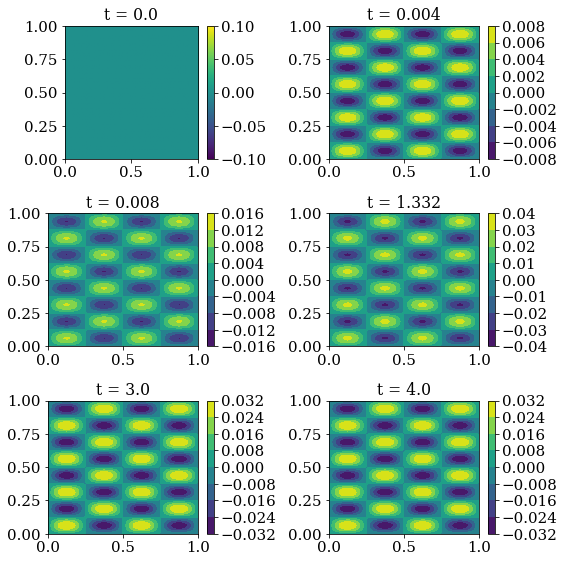

In [17]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(8, 8))

N1, N2, N3, N4, N5, N6= 0, 1, 2, Nt//3, 3*Nt//4, Nt-1


pos = ax[0, 0].imshow(res[:, :, N1].T, extent=[0,1,0,1], origin="lower")
fig.colorbar(pos, ax=ax[0, 0])
ax[0, 0].set_title("t = " + str(round(t[N1], 2)))

pos = ax[0, 1].contourf(X, Y, res[:, :, N2].T)
fig.colorbar(pos, ax=ax[0, 1])
ax[0, 1].set_title("t = " + str(round(t[N2], 3)))

pos = ax[1, 0].contourf(X, Y, res[:, :, N3].T)
fig.colorbar(pos, ax=ax[1, 0])
ax[1, 0].set_title("t = " + str(round(t[N3], 3)))

pos = ax[1, 1].contourf(X, Y, res[:, :, N4].T)
fig.colorbar(pos, ax=ax[1, 1])
ax[1, 1].set_title("t = " + str(round(t[N4], 3)))

pos = ax[2, 0].contourf(X, Y, res[:, :, N5].T)
fig.colorbar(pos, ax=ax[2, 0])
ax[2, 0].set_title("t = " + str(round(t[N5], 3)))


pos = ax[2, 1].contourf(X, Y, res[:, :, N6].T)
fig.colorbar(pos, ax=ax[2, 1])
ax[2, 1].set_title("t = " + str(round(t[N6], 3)))


plt.tight_layout()

plt.savefig("figs5/contour_plot__new_ic_d.png", dpi=600)

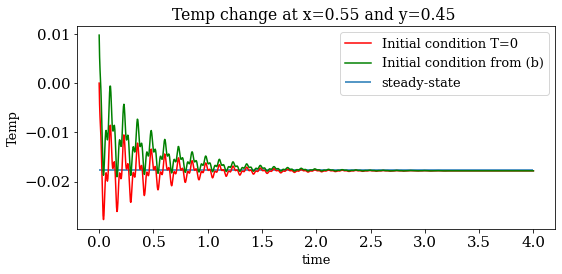

In [18]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t, res[x_coord, y_coord], c="r", label="Initial condition T=0")
ax.plot(t, res1[x_coord, y_coord], c="g", label="Initial condition from (b)")
ax.hlines(xmin=0, xmax=4, y=steady_state[x_coord, y_coord], label="steady-state")
ax.set_xlabel("time")
ax.set_ylabel("Temp")
ax.set_title("Temp change at x=0.55 and y=0.45 ")
plt.legend()
plt.tight_layout()
plt.savefig("figs5/temp_change_x_y_new_ic.png", dpi=500)